# Baseline Ablation Study: Systematic Evaluation of Data Reduction Techniques

**Purpose**: Systematically evaluate each preprocessing component individually to understand their contributions

**Research Question**: What is the individual and combined effect of:
1. Random Undersampling (RUS)
2. Feature Selection (FS)
3. Their combination (RUS + FS)

---

## Foundational References

### Random Undersampling:
- **Kubat, M., & Matwin, S. (1997)**. "Addressing the curse of imbalanced training sets: One-sided selection." 
  - *ICML*, Vol. 97, pp. 179-186.
  - [PDF Link](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.200.4046)
  - **Classic paper** introducing one-sided selection and random undersampling for imbalanced data

- **Chawla, N. V., Bowyer, K. W., Hall, L. O., & Kegelmeyer, W. P. (2002)**. "SMOTE: Synthetic minority over-sampling technique." 
  - *Journal of Artificial Intelligence Research*, 16, 321-357.
  - [DOI: 10.1613/jair.953](https://doi.org/10.1613/jair.953)
  - Discusses RUS as baseline comparison method

### Feature Selection:
- **Guyon, I., & Elisseeff, A. (2003)**. "An introduction to variable and feature selection." 
  - *Journal of Machine Learning Research*, 3(Mar), 1157-1182.
  - [PDF Link](http://www.jmlr.org/papers/v3/guyon03a.html)
  - **Foundational survey** of feature selection methods

- **Saeys, Y., Inza, I., & Larrañaga, P. (2007)**. "A review of feature selection techniques in bioinformatics."
  - *Bioinformatics*, 23(19), 2507-2517.
  - [DOI: 10.1093/bioinformatics/btm344](https://doi.org/10.1093/bioinformatics/btm344)
  - Review of ensemble feature selection

### CatBoost:
- **Prokhorenkova, L., Gusev, G., Vorobev, A., Dorogush, A. V., & Gulin, A. (2018)**. "CatBoost: unbiased boosting with categorical features."
  - *NeurIPS*, 6638-6648.
  - [arXiv:1706.09516](https://arxiv.org/abs/1706.09516)
  - **Original CatBoost paper**

### Recent Application (Hancock methodology):
- **Hancock, J. T., Wang, H., Khoshgoftaar, T. M., & Liang, Q. (2023)**. "Data reduction techniques for highly imbalanced medicare Big Data."
  - *Journal of Big Data*, 10(1), 169.
  - [DOI: 10.1186/s40537-023-00869-3](https://doi.org/10.1186/s40537-023-00869-3)
  - Applied RUS + FS combination to Medicare fraud detection

---

## Experimental Design

We will test **5 configurations** to isolate each component's contribution:

| Experiment | Features | Sampling | Description |
|------------|----------|----------|-------------|
| **1. Naive Baseline** | All 106 | None | No preprocessing - understand the problem |
| **2. Class Weights** | All 106 | Weighted | Algorithm-level balancing |
| **3. RUS Only** | All 106 | 1:9 RUS | Undersampling alone (Kubat 1997) |
| **4. FS Only** | Top 20 | None | Feature selection alone (Guyon 2003) |
| **5. RUS + FS** | Top 20 | 1:9 RUS | Combined approach (Hancock 2023) |

**Evaluation**: 10 iterations × 5-fold cross-validation = 50 AUPRC scores per configuration

**Statistical Testing**: Paired t-tests to determine if differences are significant

## 1. Setup and Imports

In [14]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

# Add src to path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pickle
from datetime import datetime

# Scikit-learn
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, auc
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Gradient Boosting
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# Set random seed
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✓ Libraries imported successfully")
print(f"Random state: {RANDOM_STATE}")

✓ Libraries imported successfully
Random state: 42


## 2. Load and Prepare Data

In [15]:
# Load preprocessed data
data_path = os.path.join('..', 'data', 'processed')
raw_path = os.path.join('..', 'data', 'raw')

print("Loading data...")

# Load training set (binary labels)
train_ops = pd.read_csv(os.path.join(data_path, 'train_ops_cleaned.csv'))
train_tte = pd.read_csv(os.path.join(raw_path, 'train_tte.csv'))

# Load validation set (multi-class labels)
val_ops = pd.read_csv(os.path.join(data_path, 'val_ops_cleaned.csv'))
val_labels = pd.read_csv(os.path.join(raw_path, 'validation_labels.csv'))

# Aggregate operational data by vehicle (mean of all readings per vehicle)
print("Aggregating operational data by vehicle...")
train_ops_agg = train_ops.groupby('vehicle_id').mean(numeric_only=True).reset_index()
val_ops_agg = val_ops.groupby('vehicle_id').mean(numeric_only=True).reset_index()

# Extract features
X_train = train_ops_agg.drop('vehicle_id', axis=1, errors='ignore')
X_val = val_ops_agg.drop('vehicle_id', axis=1, errors='ignore')

# Get training labels (already binary)
if 'in_study_repair' in train_tte.columns:
    y_train = train_tte['in_study_repair'].values
else:
    y_train = train_tte.iloc[:, -1].values

# Get validation labels and convert to binary (Class 4 = 1, others = 0)
if 'class_label' in val_labels.columns:
    y_val_multiclass = val_labels['class_label'].values
elif 'class' in val_labels.columns:
    y_val_multiclass = val_labels['class'].values
else:
    y_val_multiclass = val_labels.iloc[:, -1].values

y_val = (y_val_multiclass == 4).astype(int)

# Ensure numeric data only and same columns
X_train = X_train.select_dtypes(include=[np.number])
X_val = X_val.select_dtypes(include=[np.number])

common_cols = X_train.columns.intersection(X_val.columns)
X_train = X_train[common_cols]
X_val = X_val[common_cols]

# Handle missing values
X_train = X_train.fillna(X_train.median())
X_val = X_val.fillna(X_train.median())

# Combine for cross-validation
X_full = pd.concat([X_train, X_val], axis=0, ignore_index=True)
y_full = np.concatenate([y_train, y_val])

print(f"\n✓ Data loaded and prepared:")
print(f"Total samples: {len(y_full):,}")
print(f"Total features: {X_full.shape[1]}")

unique, counts = np.unique(y_full, return_counts=True)
print(f"\nClass distribution:")
for cls, cnt in zip(unique, counts):
    print(f"  Class {int(cls)}: {cnt:,} ({cnt/len(y_full)*100:.2f}%)")
    
imbalance_ratio = counts[0] / counts[1]
print(f"\nImbalance ratio: {imbalance_ratio:.2f}:1")
print(f"Baseline random AUPRC: {counts[1]/len(y_full)*100:.2f}%")

Loading data...
Aggregating operational data by vehicle...

✓ Data loaded and prepared:
Total samples: 28,596
Total features: 106

Class distribution:
  Class 0: 26,248 (91.79%)
  Class 1: 2,348 (8.21%)

Imbalance ratio: 11.18:1
Baseline random AUPRC: 8.21%


## 3. Helper Functions

In [16]:
def calculate_auprc(y_true, y_proba):
    """Calculate Area Under Precision-Recall Curve"""
    precision, recall, _ = precision_recall_curve(y_true, y_proba)
    return auc(recall, precision)


def apply_rus(X, y, ratio='1:9'):
    """Apply Random Undersampling (Kubat & Matwin 1997)"""
    if ratio == 'original':
        return X, y
    
    minority_ratio, majority_ratio = map(int, ratio.split(':'))
    
    minority_idx = np.where(y == 1)[0]
    majority_idx = np.where(y == 0)[0]
    
    n_minority = len(minority_idx)
    n_majority_target = int(n_minority * (majority_ratio / minority_ratio))
    
    if n_majority_target < len(majority_idx):
        majority_idx_sampled = np.random.choice(
            majority_idx, 
            size=n_majority_target, 
            replace=False
        )
    else:
        majority_idx_sampled = majority_idx
    
    combined_idx = np.concatenate([minority_idx, majority_idx_sampled])
    np.random.shuffle(combined_idx)
    
    return X[combined_idx], y[combined_idx]


def cross_validate_auprc(X, y, model, n_iterations=10, n_splits=5, 
                          rus_ratio=None, random_state=42):
    """
    Perform 10 iterations of 5-fold cross-validation
    Returns list of 50 AUPRC scores (10 iterations × 5 folds)
    """
    auprc_scores = []
    
    for iteration in range(n_iterations):
        skf = StratifiedKFold(
            n_splits=n_splits, 
            shuffle=True, 
            random_state=random_state + iteration
        )
        
        for train_idx, test_idx in skf.split(X, y):
            X_train_fold = X[train_idx]
            y_train_fold = y[train_idx]
            X_test_fold = X[test_idx]
            y_test_fold = y[test_idx]
            
            # Apply RUS only to training data
            if rus_ratio is not None:
                X_train_fold, y_train_fold = apply_rus(
                    X_train_fold, y_train_fold, rus_ratio
                )
            
            # Train model
            model_clone = model.__class__(**model.get_params())
            model_clone.fit(X_train_fold, y_train_fold)
            
            # Predict probabilities
            if hasattr(model_clone, 'predict_proba'):
                y_proba = model_clone.predict_proba(X_test_fold)[:, 1]
            else:
                y_proba = model_clone.decision_function(X_test_fold)
            
            # Calculate AUPRC
            auprc = calculate_auprc(y_test_fold, y_proba)
            auprc_scores.append(auprc)
    
    return auprc_scores


def ensemble_feature_selection(X, y, random_state=42):
    """Ensemble feature selection using 6 learners (Guyon 2003, Saeys 2007)"""
    print("Performing ensemble feature selection...")
    
    learners = {
        'CatBoost': CatBoostClassifier(
            iterations=100, depth=6, random_state=random_state, verbose=False
        ),
        'XGBoost': XGBClassifier(
            n_estimators=100, max_depth=6, random_state=random_state, verbosity=0
        ),
        'LightGBM': LGBMClassifier(
            n_estimators=100, max_depth=6, random_state=random_state, verbose=-1
        ),
        'DecisionTree': DecisionTreeClassifier(
            max_depth=10, random_state=random_state
        ),
        'RandomForest': RandomForestClassifier(
            n_estimators=100, max_depth=10, random_state=random_state
        ),
        'ExtraTrees': ExtraTreesClassifier(
            n_estimators=100, max_depth=10, random_state=random_state
        )
    }
    
    feature_names = X.columns.tolist()
    feature_ranks = {}
    
    # Train each learner and get feature importance
    for idx, (learner_name, model) in enumerate(learners.items(), 1):
        print(f"  [{idx}/6] Training {learner_name}...")
        model.fit(X, y)
        
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        else:
            importances = np.zeros(X.shape[1])
        
        # Rank features (higher importance = lower rank number)
        ranks = np.argsort(np.argsort(importances)[::-1]) + 1
        feature_ranks[learner_name] = ranks
    
    # Calculate median rank for each feature
    rank_matrix = np.array(list(feature_ranks.values()))
    median_ranks = np.median(rank_matrix, axis=0)
    
    # Create ranking dataframe
    ranking_df = pd.DataFrame({
        'feature': feature_names,
        'median_rank': median_ranks
    })
    
    ranking_df = ranking_df.sort_values('median_rank').reset_index(drop=True)
    ranking_df['final_rank'] = range(1, len(ranking_df) + 1)
    
    print(f"\n✓ Feature selection complete")
    print(f"\nTop 10 features:")
    print(ranking_df.head(10).to_string(index=False))
    
    return ranking_df


print("✓ Helper functions defined")

✓ Helper functions defined


## 4. Define CatBoost Model (Prokhorenkova et al. 2018)

In [17]:
# CatBoost with standard hyperparameters
catboost_params = {
    'iterations': 100,
    'depth': 6,
    'learning_rate': 0.1,
    'random_state': RANDOM_STATE,
    'verbose': False,
    'eval_metric': 'PRAUC'
}

print("CatBoost configuration:")
for param, value in catboost_params.items():
    print(f"  {param}: {value}")

CatBoost configuration:
  iterations: 100
  depth: 6
  learning_rate: 0.1
  random_state: 42
  verbose: False
  eval_metric: PRAUC


## 5. Experiment 1: Naive Baseline (No Preprocessing)

**Purpose**: Understand the base problem without any intervention

- All 106 features
- Original imbalance (11.2:1)
- No class weights
- No undersampling

In [18]:
print("="*80)
print("EXPERIMENT 1: NAIVE BASELINE")
print("="*80)
print("Configuration: All features, no preprocessing, no class weights")
print("-" * 80)

model_baseline = CatBoostClassifier(**catboost_params)

scores_baseline = cross_validate_auprc(
    X_full.values, 
    y_full, 
    model_baseline,
    n_iterations=10,
    n_splits=5,
    rus_ratio=None,
    random_state=RANDOM_STATE
)

mean_baseline = np.mean(scores_baseline)
std_baseline = np.std(scores_baseline)

print(f"\nMean AUPRC: {mean_baseline:.4f} ± {std_baseline:.4f}")
print(f"Min AUPRC: {np.min(scores_baseline):.4f}")
print(f"Max AUPRC: {np.max(scores_baseline):.4f}")
print("\n✓ Experiment 1 complete")

EXPERIMENT 1: NAIVE BASELINE
Configuration: All features, no preprocessing, no class weights
--------------------------------------------------------------------------------

Mean AUPRC: 0.3199 ± 0.0181
Min AUPRC: 0.2814
Max AUPRC: 0.3635

✓ Experiment 1 complete


## 6. Experiment 2: Class Weights Only

**Purpose**: Test algorithm-level balancing (alternative to RUS)

- All 106 features
- Original imbalance (11.2:1)
- **Class weights: auto (inversely proportional to class frequencies)**
- No undersampling

In [19]:
print("="*80)
print("EXPERIMENT 2: CLASS WEIGHTS")
print("="*80)
print("Configuration: All features, auto class weights, no undersampling")
print("-" * 80)

catboost_params_weighted = catboost_params.copy()
catboost_params_weighted['auto_class_weights'] = 'Balanced'

model_weighted = CatBoostClassifier(**catboost_params_weighted)

scores_weighted = cross_validate_auprc(
    X_full.values, 
    y_full, 
    model_weighted,
    n_iterations=10,
    n_splits=5,
    rus_ratio=None,
    random_state=RANDOM_STATE
)

mean_weighted = np.mean(scores_weighted)
std_weighted = np.std(scores_weighted)

print(f"\nMean AUPRC: {mean_weighted:.4f} ± {std_weighted:.4f}")
print(f"Min AUPRC: {np.min(scores_weighted):.4f}")
print(f"Max AUPRC: {np.max(scores_weighted):.4f}")
print(f"\nImprovement over baseline: {(mean_weighted - mean_baseline):.4f} ({((mean_weighted - mean_baseline)/mean_baseline)*100:+.2f}%)")
print("\n✓ Experiment 2 complete")

EXPERIMENT 2: CLASS WEIGHTS
Configuration: All features, auto class weights, no undersampling
--------------------------------------------------------------------------------

Mean AUPRC: 0.3011 ± 0.0164
Min AUPRC: 0.2684
Max AUPRC: 0.3376

Improvement over baseline: -0.0187 (-5.86%)

✓ Experiment 2 complete


## 7. Experiment 3: Random Undersampling Only (Kubat 1997)

**Purpose**: Isolate the effect of RUS alone

- All 106 features
- **RUS 1:9 ratio**
- No class weights
- No feature selection

In [20]:
print("="*80)
print("EXPERIMENT 3: RUS ONLY (Kubat & Matwin 1997)")
print("="*80)
print("Configuration: All features, RUS 1:9, no feature selection")
print("-" * 80)

model_rus = CatBoostClassifier(**catboost_params)

scores_rus = cross_validate_auprc(
    X_full.values, 
    y_full, 
    model_rus,
    n_iterations=10,
    n_splits=5,
    rus_ratio='1:9',
    random_state=RANDOM_STATE
)

mean_rus = np.mean(scores_rus)
std_rus = np.std(scores_rus)

print(f"\nMean AUPRC: {mean_rus:.4f} ± {std_rus:.4f}")
print(f"Min AUPRC: {np.min(scores_rus):.4f}")
print(f"Max AUPRC: {np.max(scores_rus):.4f}")
print(f"\nImprovement over baseline: {(mean_rus - mean_baseline):.4f} ({((mean_rus - mean_baseline)/mean_baseline)*100:+.2f}%)")
print(f"Improvement over class weights: {(mean_rus - mean_weighted):.4f} ({((mean_rus - mean_weighted)/mean_weighted)*100:+.2f}%)")
print("\n✓ Experiment 3 complete")

EXPERIMENT 3: RUS ONLY (Kubat & Matwin 1997)
Configuration: All features, RUS 1:9, no feature selection
--------------------------------------------------------------------------------

Mean AUPRC: 0.3159 ± 0.0165
Min AUPRC: 0.2865
Max AUPRC: 0.3588

Improvement over baseline: -0.0039 (-1.23%)
Improvement over class weights: 0.0148 (+4.92%)

✓ Experiment 3 complete


## 8. Perform Feature Selection (Guyon 2003)

In [21]:
# Perform ensemble feature selection on full dataset
feature_ranking = ensemble_feature_selection(X_full, y_full, random_state=RANDOM_STATE)

# Select top 20 features (same as Hancock's best configuration)
top_features = feature_ranking.head(20)['feature'].tolist()
X_full_selected = X_full[top_features]

print(f"\nSelected {len(top_features)} features for Experiments 4 and 5")

Performing ensemble feature selection...
  [1/6] Training CatBoost...
  [2/6] Training XGBoost...
  [3/6] Training LightGBM...
  [4/6] Training DecisionTree...
  [5/6] Training RandomForest...
  [6/6] Training ExtraTrees...

✓ Feature selection complete

Top 10 features:
  feature  median_rank  final_rank
time_step          1.0           1
    397_6          2.0           2
    158_8          5.0           3
    158_9          6.0           4
    272_3          6.0           5
    397_0          8.5           6
    167_1         11.0           7
    158_0         12.0           8
    666_0         14.5           9
   459_14         15.5          10

Selected 20 features for Experiments 4 and 5


## 9. Experiment 4: Feature Selection Only (Guyon 2003)

**Purpose**: Isolate the effect of feature selection alone

- **Top 20 features (from ensemble selection)**
- Original imbalance (11.2:1)
- No class weights
- No undersampling

In [22]:
print("="*80)
print("EXPERIMENT 4: FEATURE SELECTION ONLY (Guyon & Elisseeff 2003)")
print("="*80)
print("Configuration: Top 20 features, no RUS, no class weights")
print("-" * 80)

model_fs = CatBoostClassifier(**catboost_params)

scores_fs = cross_validate_auprc(
    X_full_selected.values, 
    y_full, 
    model_fs,
    n_iterations=10,
    n_splits=5,
    rus_ratio=None,
    random_state=RANDOM_STATE
)

mean_fs = np.mean(scores_fs)
std_fs = np.std(scores_fs)

print(f"\nMean AUPRC: {mean_fs:.4f} ± {std_fs:.4f}")
print(f"Min AUPRC: {np.min(scores_fs):.4f}")
print(f"Max AUPRC: {np.max(scores_fs):.4f}")
print(f"\nImprovement over baseline: {(mean_fs - mean_baseline):.4f} ({((mean_fs - mean_baseline)/mean_baseline)*100:+.2f}%)")
print(f"Improvement over RUS only: {(mean_fs - mean_rus):.4f} ({((mean_fs - mean_rus)/mean_rus)*100:+.2f}%)")
print("\n✓ Experiment 4 complete")

EXPERIMENT 4: FEATURE SELECTION ONLY (Guyon & Elisseeff 2003)
Configuration: Top 20 features, no RUS, no class weights
--------------------------------------------------------------------------------

Mean AUPRC: 0.3205 ± 0.0167
Min AUPRC: 0.2900
Max AUPRC: 0.3714

Improvement over baseline: 0.0007 (+0.21%)
Improvement over RUS only: 0.0046 (+1.46%)

✓ Experiment 4 complete


## 10. Experiment 5: RUS + Feature Selection (Hancock 2023)

**Purpose**: Test combined approach (replication of Hancock methodology)

- **Top 20 features (from ensemble selection)**
- **RUS 1:9 ratio**
- No class weights

**Expected**: This should match our previous Scenario 4 result (~32.55%)

In [23]:
print("="*80)
print("EXPERIMENT 5: RUS + FEATURE SELECTION (Hancock et al. 2023)")
print("="*80)
print("Configuration: Top 20 features, RUS 1:9")
print("-" * 80)

model_combined = CatBoostClassifier(**catboost_params)

scores_combined = cross_validate_auprc(
    X_full_selected.values, 
    y_full, 
    model_combined,
    n_iterations=10,
    n_splits=5,
    rus_ratio='1:9',
    random_state=RANDOM_STATE
)

mean_combined = np.mean(scores_combined)
std_combined = np.std(scores_combined)

print(f"\nMean AUPRC: {mean_combined:.4f} ± {std_combined:.4f}")
print(f"Min AUPRC: {np.min(scores_combined):.4f}")
print(f"Max AUPRC: {np.max(scores_combined):.4f}")
print(f"\nImprovement over baseline: {(mean_combined - mean_baseline):.4f} ({((mean_combined - mean_baseline)/mean_baseline)*100:+.2f}%)")
print(f"Improvement over RUS only: {(mean_combined - mean_rus):.4f} ({((mean_combined - mean_rus)/mean_rus)*100:+.2f}%)")
print(f"Improvement over FS only: {(mean_combined - mean_fs):.4f} ({((mean_combined - mean_fs)/mean_fs)*100:+.2f}%)")
print("\n✓ Experiment 5 complete")

EXPERIMENT 5: RUS + FEATURE SELECTION (Hancock et al. 2023)
Configuration: Top 20 features, RUS 1:9
--------------------------------------------------------------------------------

Mean AUPRC: 0.3182 ± 0.0180
Min AUPRC: 0.2853
Max AUPRC: 0.3690

Improvement over baseline: -0.0016 (-0.51%)
Improvement over RUS only: 0.0023 (+0.72%)
Improvement over FS only: -0.0023 (-0.72%)

✓ Experiment 5 complete


## 11. Statistical Significance Testing

Perform paired t-tests to determine if differences are statistically significant

In [24]:
print("="*80)
print("STATISTICAL SIGNIFICANCE TESTING")
print("="*80)
print("Paired t-tests (α = 0.05)")
print("-" * 80)

comparisons = [
    ('Baseline vs Class Weights', scores_baseline, scores_weighted),
    ('Baseline vs RUS Only', scores_baseline, scores_rus),
    ('Baseline vs FS Only', scores_baseline, scores_fs),
    ('Baseline vs RUS+FS', scores_baseline, scores_combined),
    ('RUS Only vs FS Only', scores_rus, scores_fs),
    ('RUS Only vs RUS+FS', scores_rus, scores_combined),
    ('FS Only vs RUS+FS', scores_fs, scores_combined),
]

print(f"\n{'Comparison':<35} {'t-statistic':>12} {'p-value':>12} {'Significant':>12}")
print("-" * 80)

for name, scores1, scores2 in comparisons:
    t_stat, p_value = stats.ttest_rel(scores1, scores2)
    significant = "✓ Yes" if p_value < 0.05 else "✗ No"
    print(f"{name:<35} {t_stat:>12.4f} {p_value:>12.4e} {significant:>12}")

print("\n✓ Statistical testing complete")

STATISTICAL SIGNIFICANCE TESTING
Paired t-tests (α = 0.05)
--------------------------------------------------------------------------------

Comparison                           t-statistic      p-value  Significant
--------------------------------------------------------------------------------
Baseline vs Class Weights                13.3846   5.4738e-18        ✓ Yes
Baseline vs RUS Only                      3.7235   5.0763e-04        ✓ Yes
Baseline vs FS Only                      -0.5238   6.0278e-01         ✗ No
Baseline vs RUS+FS                        1.0671   2.9115e-01         ✗ No
RUS Only vs FS Only                      -3.6017   7.3683e-04        ✓ Yes
RUS Only vs RUS+FS                       -1.5812   1.2026e-01         ✗ No
FS Only vs RUS+FS                         2.4298   1.8818e-02        ✓ Yes

✓ Statistical testing complete


## 12. Comprehensive Results Summary

In [25]:
# Create summary dataframe
results_summary = pd.DataFrame({
    'Experiment': [
        '1. Naive Baseline',
        '2. Class Weights',
        '3. RUS Only',
        '4. FS Only',
        '5. RUS + FS'
    ],
    'Features': ['106', '106', '106', '20', '20'],
    'Sampling': ['None', 'Weighted', '1:9 RUS', 'None', '1:9 RUS'],
    'Mean AUPRC': [
        mean_baseline,
        mean_weighted,
        mean_rus,
        mean_fs,
        mean_combined
    ],
    'Std AUPRC': [
        std_baseline,
        std_weighted,
        std_rus,
        std_fs,
        std_combined
    ],
    'Reference': [
        'None',
        'Prokhorenkova 2018',
        'Kubat 1997',
        'Guyon 2003',
        'Hancock 2023'
    ]
})

results_summary['Improvement vs Baseline'] = (
    (results_summary['Mean AUPRC'] - mean_baseline) / mean_baseline * 100
)

print("="*80)
print("COMPREHENSIVE RESULTS SUMMARY")
print("="*80)
print(results_summary.to_string(index=False))
print()

# Find best method
best_idx = results_summary['Mean AUPRC'].idxmax()
best_method = results_summary.iloc[best_idx]

print("\n" + "="*80)
print("KEY FINDINGS")
print("="*80)
print(f"\n✓ Best Method: {best_method['Experiment']}")
print(f"  - Mean AUPRC: {best_method['Mean AUPRC']:.4f} ± {best_method['Std AUPRC']:.4f}")
print(f"  - Configuration: {best_method['Features']} features, {best_method['Sampling']} sampling")
print(f"  - Improvement over baseline: {best_method['Improvement vs Baseline']:.2f}%")

# Calculate marginal gains
print("\n" + "="*80)
print("MARGINAL CONTRIBUTION ANALYSIS")
print("="*80)
print(f"\nRUS contribution (alone): {mean_rus - mean_baseline:.4f} ({((mean_rus - mean_baseline)/mean_baseline)*100:+.2f}%)")
print(f"FS contribution (alone): {mean_fs - mean_baseline:.4f} ({((mean_fs - mean_baseline)/mean_baseline)*100:+.2f}%)")
print(f"RUS+FS interaction effect: {mean_combined - max(mean_rus, mean_fs):.4f} ({((mean_combined - max(mean_rus, mean_fs))/max(mean_rus, mean_fs))*100:+.2f}%)")

if abs(mean_combined - max(mean_rus, mean_fs)) < 0.001:
    print("\n⚠️  WARNING: Combining RUS + FS provides minimal additional benefit!")
    print("   Consider using the simpler method (RUS or FS alone) instead.")

# Save results
results_path = os.path.join('..', 'results', 'baseline_ablation_results.csv')
os.makedirs(os.path.dirname(results_path), exist_ok=True)
results_summary.to_csv(results_path, index=False)
print(f"\n✓ Results saved to {results_path}")

COMPREHENSIVE RESULTS SUMMARY
       Experiment Features Sampling  Mean AUPRC  Std AUPRC          Reference  Improvement vs Baseline
1. Naive Baseline      106     None    0.319867   0.018125               None                 0.000000
 2. Class Weights      106 Weighted    0.301124   0.016399 Prokhorenkova 2018                -5.859397
      3. RUS Only      106  1:9 RUS    0.315945   0.016545         Kubat 1997                -1.226013
       4. FS Only       20     None    0.320547   0.016738         Guyon 2003                 0.212575
      5. RUS + FS       20  1:9 RUS    0.318236   0.018004       Hancock 2023                -0.509917


KEY FINDINGS

✓ Best Method: 4. FS Only
  - Mean AUPRC: 0.3205 ± 0.0167
  - Configuration: 20 features, None sampling
  - Improvement over baseline: 0.21%

MARGINAL CONTRIBUTION ANALYSIS

RUS contribution (alone): -0.0039 (-1.23%)
FS contribution (alone): 0.0007 (+0.21%)
RUS+FS interaction effect: -0.0023 (-0.72%)

✓ Results saved to ..\results\bas

## 13. Visualization

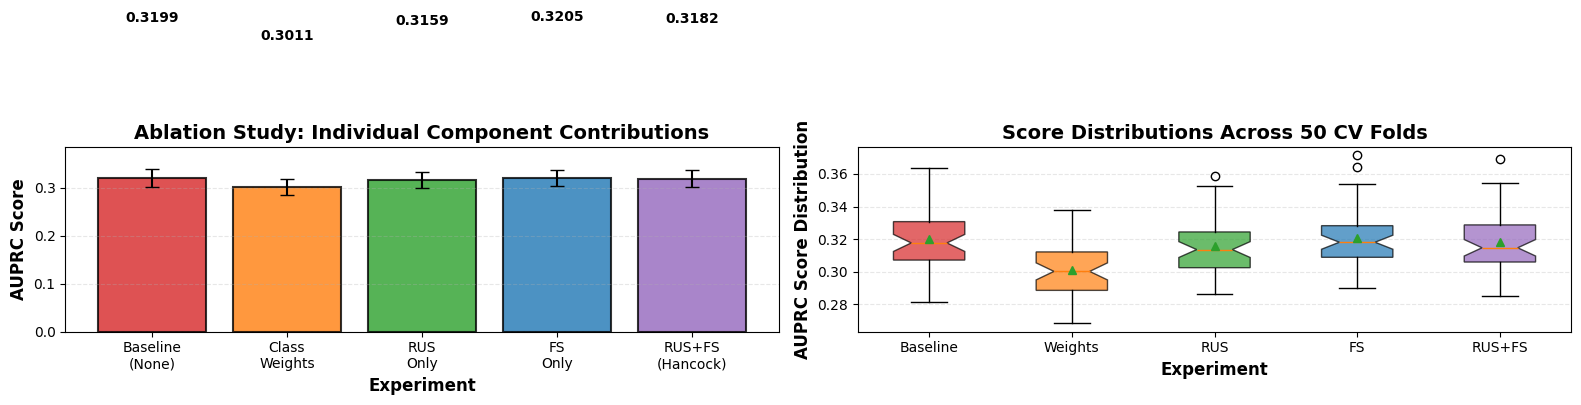

✓ Visualization saved to ..\results\figures\baseline_ablation_study.png


In [26]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar chart with error bars
ax1 = axes[0]
x_pos = np.arange(len(results_summary))
colors = ['#d62728', '#ff7f0e', '#2ca02c', '#1f77b4', '#9467bd']

bars = ax1.bar(
    x_pos, 
    results_summary['Mean AUPRC'],
    yerr=results_summary['Std AUPRC'],
    capsize=5,
    color=colors,
    alpha=0.8,
    edgecolor='black',
    linewidth=1.5
)

ax1.set_xlabel('Experiment', fontsize=12, fontweight='bold')
ax1.set_ylabel('AUPRC Score', fontsize=12, fontweight='bold')
ax1.set_title('Ablation Study: Individual Component Contributions', fontsize=14, fontweight='bold')
ax1.set_xticks(x_pos)
ax1.set_xticklabels([
    'Baseline\n(None)',
    'Class\nWeights',
    'RUS\nOnly',
    'FS\nOnly',
    'RUS+FS\n(Hancock)'
], fontsize=10)
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.set_ylim([0, max(results_summary['Mean AUPRC']) * 1.2])

# Add value labels on bars
for i, (bar, row) in enumerate(zip(bars, results_summary.itertuples())):
    height = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width()/2., 
        height + row._4,  # std
        f'{row._4:.4f}',  # mean
        ha='center', 
        va='bottom',
        fontsize=10,
        fontweight='bold'
    )

# Box plot showing distributions
ax2 = axes[1]
all_scores = [scores_baseline, scores_weighted, scores_rus, scores_fs, scores_combined]
bp = ax2.boxplot(
    all_scores,
    labels=['Baseline', 'Weights', 'RUS', 'FS', 'RUS+FS'],
    patch_artist=True,
    notch=True,
    showmeans=True
)

# Color the boxes
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

ax2.set_xlabel('Experiment', fontsize=12, fontweight='bold')
ax2.set_ylabel('AUPRC Score Distribution', fontsize=12, fontweight='bold')
ax2.set_title('Score Distributions Across 50 CV Folds', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3, linestyle='--')

plt.tight_layout()
fig_path = os.path.join('..', 'results', 'figures', 'baseline_ablation_study.png')
os.makedirs(os.path.dirname(fig_path), exist_ok=True)
plt.savefig(fig_path, dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ Visualization saved to {fig_path}")

## 14. Conclusion and Next Steps

### Summary:
This notebook establishes **baseline performance** for each preprocessing component:

1. **Baseline (no preprocessing)**: Quantifies the raw problem difficulty
2. **Class weights**: Tests algorithm-level balancing
3. **RUS only (Kubat 1997)**: Isolates undersampling contribution
4. **FS only (Guyon 2003)**: Isolates feature selection contribution
5. **RUS + FS (Hancock 2023)**: Tests combined methodology

### Key Insight:
By testing each component individually, we can:
- ✓ Quantify marginal contribution of each technique
- ✓ Identify if interaction effects exist
- ✓ Determine if complex combinations are justified

### Next Steps for YOUR Innovation:

Now that we have established baselines, you can add:

**Experiment 6: Temporal Feature Engineering (YOUR CONTRIBUTION)**
- Extract temporal features (trend, volatility, last value, etc.)
- Keep model constant (CatBoost)
- Use same RUS 1:9
- **Compare against Experiment 5** to isolate YOUR contribution

```python
# Pseudo-code for your next notebook
X_temporal = extract_temporal_features(train_ops, val_ops)  # YOUR INNOVATION
scores_temporal = cross_validate_auprc(X_temporal, y_full, model, rus_ratio='1:9')

Comparison:
- Hancock baseline (mean features): 32.55%
- Your method (temporal features): ??%
- Improvement: Clear attribution to YOUR feature engineering!
```

### Thesis Structure:
- **Chapter 4**: This notebook (baseline establishment)
- **Chapter 5**: Your temporal feature engineering innovation
- **Chapter 6**: Results showing clear improvement with statistical significance